In [1]:
!pip install pandas numpy scikit-learn matplotlib


In [2]:

import pandas as pd

# Load raw CSV
df = pd.read_csv("telco_churn_raw.csv")

# Strip whitespace from column names
df.columns = [c.strip() for c in df.columns]

# Fix TotalCharges column (it has blank/space values that break numeric conversion)
df["TotalCharges"] = df["TotalCharges"].replace(" ", pd.NA)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows where TotalCharges or tenure or MonthlyCharges are missing
df = df.dropna(subset=["TotalCharges", "tenure", "MonthlyCharges"])

# Convert SeniorCitizen to int (0/1)
df["SeniorCitizen"] = df["SeniorCitizen"].astype(int)

# Encode target column
df["ChurnLabel"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Reset index after clean
df = df.reset_index(drop=True)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ChurnLabel
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [3]:
df.to_csv("telco_churn_clean.csv", index=False)
print("Saved cleaned dataset as telco_churn_clean.csv")


Saved cleaned dataset as telco_churn_clean.csv


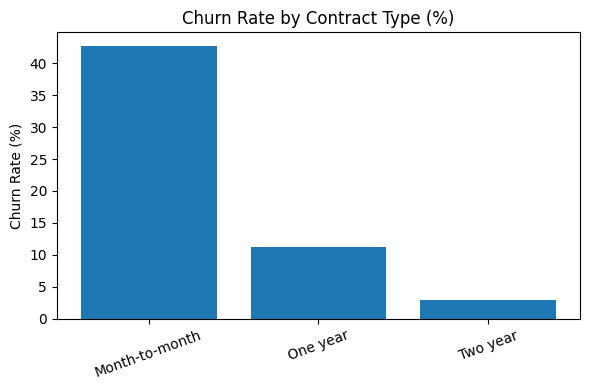

/tmp/ipython-input-2241465189.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("TenureBucket")["ChurnLabel"]


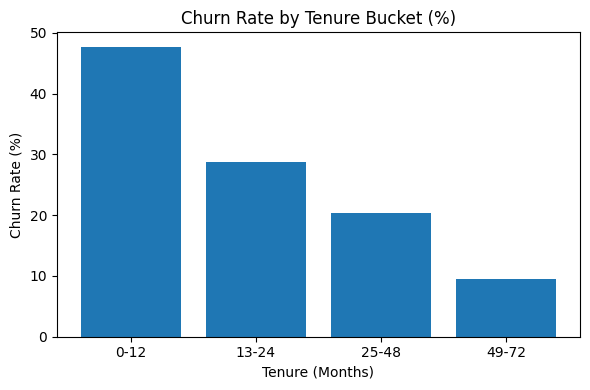

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("telco_churn_clean.csv")

# 1️⃣ Churn rate by contract type
contract_churn = (
    df.groupby("Contract")["ChurnLabel"]
    .mean()
    .reset_index()
    .rename(columns={"ChurnLabel": "ChurnRate"})
)

plt.figure(figsize=(6,4))
plt.bar(contract_churn["Contract"], contract_churn["ChurnRate"] * 100)
plt.title("Churn Rate by Contract Type (%)")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("churn_by_contract.png")
plt.show()


# 2️⃣ Churn rate by tenure bucket
df["TenureBucket"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 72],
    labels=["0-12", "13-24", "25-48", "49-72"]
)
tenure_churn = (
    df.groupby("TenureBucket")["ChurnLabel"]
    .mean()
    .reset_index()
    .rename(columns={"ChurnLabel": "ChurnRate"})
)

plt.figure(figsize=(6,4))
plt.bar(tenure_churn["TenureBucket"], tenure_churn["ChurnRate"] * 100)
plt.title("Churn Rate by Tenure Bucket (%)")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Tenure (Months)")
plt.tight_layout()
plt.savefig("churn_by_tenure.png")
plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Load cleaned dataset
df = pd.read_csv("telco_churn_clean.csv")

# Target and input features
target = "ChurnLabel"
y = df[target]
X = df.drop(columns=[target, "customerID", "Churn"], errors="ignore")

# Split numeric & categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Define model
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

# Build pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.78      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407


Confusion Matrix:
[[927 106]
 [197 177]]


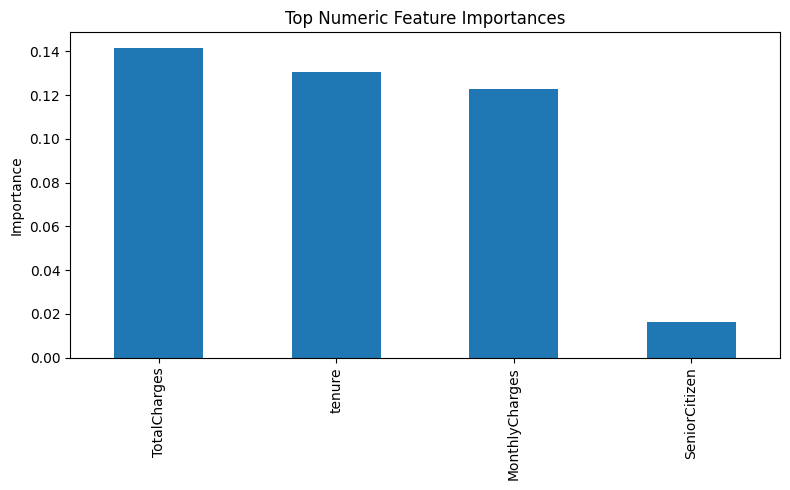

In [6]:
# Feature importance visualization
rf_model = model.named_steps["classifier"]
importances = rf_model.feature_importances_

# Only numeric feature importances (simplified)
feature_importance = pd.Series(
    importances[:len(numeric_features)],
    index=numeric_features
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feature_importance.head(10).plot(kind="bar")
plt.title("Top Numeric Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()
